# "Bouston-Housing Regression"
> "Predicting "MEDV" feature by using Bouston-Housing Dataset"

- toc: false
- branch: master
- badges: true
- comments: true
- categories: [jupyter, pytorch, pytorch-lightning]
- hide: false
- search_exclude: true

In [1]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, MinMaxScaler

In [2]:
path = 'D:\Study\Boston Dataset\Boston.csv'
df = pd.read_csv(path)
df, test_df = train_test_split(df)
df.head()

,Unnamed: 0,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
159,160,1.42502,0.0,19.58,0,0.871,6.510,100.0,1.7659,5,403,14.7,364.31,7.39,23.3
363,364,4.22239,0.0,18.10,1,0.770,5.803,89.0,1.9047,24,666,20.2,353.04,14.64,16.8
359,360,4.26131,0.0,18.10,0,0.770,6.112,81.3,2.5091,24,666,20.2,390.74,12.67,22.6
172,173,0.13914,0.0,4.05,0,0.510,5.572,88.5,2.5961,5,296,16.6,396.90,14.69,23.1
479,480,14.33370,0.0,18.10,0,0.614,6.229,88.0,1.9512,24,666,20.2,383.32,13.11,21.4


In [3]:
test_df

,Unnamed: 0,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
83,84,0.03551,25.0,4.86,0,0.426,6.167,46.7,5.4007,4,281,19.0,390.64,7.51,22.9
459,460,6.80117,0.0,18.10,0,0.713,6.081,84.4,2.7175,24,666,20.2,396.90,14.70,20.0
458,459,7.75223,0.0,18.10,0,0.713,6.301,83.7,2.7831,24,666,20.2,272.21,16.23,14.9
225,226,0.52693,0.0,6.20,0,0.504,8.725,83.0,2.8944,8,307,17.4,382.00,4.63,50.0
438,439,13.67810,0.0,18.10,0,0.740,5.935,87.9,1.8206,24,666,20.2,68.95,34.02,8.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,73,0.09164,0.0,10.81,0,0.413,6.065,7.8,5.2873,4,305,19.2,390.91,5.52,22.8
251,252,0.21409,22.0,5.86,0,0.431,6.438,8.9,7.3967,7,330,19.1,377.07,3.59,24.8
320,321,0.16760,0.0,7.38,0,0.493,6.426,52.3,4.5404,5,287,19.6,396.90,7.20,23.8
414,415,45.74610,0.0,18.10,0,0.693,4.519,100.0,1.6582,24,666,20.2,88.27,36.98,7.0


In [4]:
len(df), len(test_df)

(379, 127)

In [5]:
x = MinMaxScaler()
x.fit(df.values)
y = x.transform(df.values)
z = x.inverse_transform(y)
# df.values, z
y

array([[3.12127237e-01, 1.92328565e-02, 0.00000000e+00, ...,
        9.17363964e-01, 1.56181015e-01, 4.06666667e-01],
       [7.17693837e-01, 5.72803338e-02, 0.00000000e+00, ...,
        8.88787464e-01, 3.56236203e-01, 2.62222222e-01],
       [7.09741551e-01, 5.78096909e-02, 0.00000000e+00, ...,
        9.84380547e-01, 3.01876380e-01, 3.91111111e-01],
       ...,
       [4.73161034e-01, 1.39180672e-03, 3.00000000e-01, ...,
        9.85673716e-01, 2.66280353e-01, 3.77777778e-01],
       [2.80318091e-01, 5.55803248e-02, 0.00000000e+00, ...,
        1.00000000e+00, 6.81291391e-01, 2.35555556e-01],
       [6.69980119e-01, 5.98587057e-04, 0.00000000e+00, ...,
        1.00000000e+00, 2.21026490e-01, 3.11111111e-01]])

In [6]:
class BostonDS(Dataset):
    x_col = ['crim','zn','indus','nox','rm','age','dis','tax','ptratio','black','lstat']
    y_col = ['medv']
    def __init__(self, df, scalers=None):
        super().__init__()
        self.df = df
        if scalers is None:
            self.input_scaler = MinMaxScaler()
            self.output_scaler = MinMaxScaler()
            self.x = self.input_scaler.fit_transform(self.df[self.x_col])
            self.y = self.output_scaler.fit_transform(self.df[self.y_col])
        else:
            self.input_scaler, self.output_scaler = scalers
            self.x = self.input_scaler.transform(self.df[self.x_col])
            self.y = self.output_scaler.transform(self.df[self.y_col])
        self.scalers = (self.input_scaler, self.output_scaler)
        
    def __getitem__(self, ix):
        features = torch.tensor(self.x[ix]).float()
        target = torch.tensor(self.y[ix]).float()
        return features, target
        
    def __len__(self):
        return len(self.x)
        
class BostonDM(pl.LightningDataModule):
    def __init__(self, df):
        super().__init__()
        self.trn_df, self.val_df = train_test_split(df)
        self.trn_ds = BostonDS(self.trn_df)
        self.val_ds = BostonDS(self.val_df, scalers=self.trn_ds.scalers)
        
    def train_dataloader(self):
        return DataLoader(self.trn_ds, batch_size=32, shuffle=True)
    
    def val_dataloader(self):
         return DataLoader(self.val_ds, batch_size=32)
        
dm = BostonDM(df)

In [7]:
class Net(pl.LightningModule):
    def linear_layer(self,ni,no):
        return nn.Sequential(
            nn.Linear(ni,no),
            nn.ReLU(inplace=True)
        )
    
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            self.linear_layer(11, 32),
            self.linear_layer(32, 64)
        )
        self.lin = nn.Linear(64,1)
        self.loss_fn = nn.MSELoss()
        
    def forward(self,x):
        x = self.fc(x)
        x = self.lin(x)
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x.float())
        loss = self.loss_fn(y_hat, y)
        return {'loss':loss}
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x.float())
        loss = self.loss_fn(y_hat, y)
        return {'loss':loss}
        
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=1e-3)
    
    def predict(self, test, inv_t):
        if len(test) == 1:
            x,_ = test
            preds = self(x.float())
            preds = inv_t.inverse_transform(preds)
            return preds
        else:
            preds = []
            for i in range(len(test)):
                x,_ = test[i]
                pred = self(x.float())
                preds.append(pred)
            preds = torch.tensor(preds).view(-1,1)
            preds = inv_t.inverse_transform(preds)
            return preds
            
    def get_progress_bar_dict(self):
        tqdm_dict = super().get_progress_bar_dict()
        if 'v_num' in tqdm_dict:
            del tqdm_dict['v_num']
        return tqdm_dict

In [8]:
if __name__ == '__main__':
    model = Net()
    trainer = pl.Trainer(max_epochs=200, gpus=[0])
    trainer.fit(model, dm)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | fc      | Sequential | 2.5 K 
1 | lin     | Linear     | 65    
2 | loss_fn | MSELoss    | 0     
---------------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params


In [9]:
# test_ds = BostonDS(test_df, dm.trn_ds.scalers)
# _y, y = model.predict(test_ds)
# _, outsc = dm.trn_ds.scalers
# _y = _y.view(-1,1)
# y = y.view(-1,1)
# _y = outsc.inverse_transform(_y)
# y = outsc.inverse_transform(y)

In [10]:
test_ds = BostonDS(test_df, dm.trn_ds.scalers)
_, inv_t = dm.trn_ds.scalers
preds = model.predict(test_ds, inv_t)

preds

array([[21.82140812],
       [16.68913797],
       [13.58146355],
       [47.22882479],
       [ 4.74462621],
       [22.41462693],
       [27.0130758 ],
       [15.3748931 ],
       [19.61103991],
       [36.13087922],
       [20.50693259],
       [13.93692598],
       [11.95510745],
       [25.36681369],
       [17.82088667],
       [21.69055656],
       [17.256338  ],
       [12.19783932],
       [26.10875964],
       [14.05675098],
       [14.82883424],
       [11.66689336],
       [43.09464753],
       [13.98806095],
       [13.12441111],
       [31.15622371],
       [13.33665431],
       [26.94362536],
       [31.51289582],
       [32.45961905],
       [29.84122783],
       [22.18970761],
       [45.08382201],
       [18.432661  ],
       [28.8835907 ],
       [16.0408105 ],
       [22.46026739],
       [16.24880776],
       [20.9618701 ],
       [17.29790688],
       [14.13784087],
       [22.19073221],
       [22.81654924],
       [20.88509053],
       [14.79819402],
       [27

C:\Users\Rajiv Reddy\miniconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Rajiv Reddy\miniconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

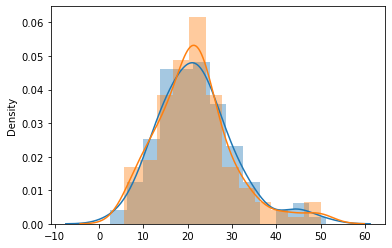

In [13]:
import seaborn as sns
sns.distplot(preds)
sns.distplot(test_df['medv'].values)

In [12]:
for i in range(10):
    print(preds[i], test_df['medv'].values[i])

[21.82140812] 22.9
[16.68913797] 20.0
[13.58146355] 14.9
[47.22882479] 50.0
[4.74462621] 8.4
[22.41462693] 21.6
[27.0130758] 24.6
[15.3748931] 14.0
[19.61103991] 16.1
[36.13087922] 27.0
